# **Satellite Derived Bathymetry with sample elevation data by Google Earth Engine**

การทำแบบจำลองความลึกท้องน้ำตื้นโดยใช้ภาพถ่ายดาวเทียม Sentinel 2 (L2A : Bottom of the atmosphere) แปลงค่าการสะท้อนในช่วงคลื่นสีน้ำเงินและเขียวเป็นความลึกของน้ำผ่านสมการเชิงประจักษ์ (Empirical formula) สำหรับพื้นที่ชายฝั่งทะเล


**ต้องการข้อมูลค่ารังวัดภาคสนามประกอบการทำแบบจำลอง**


Thepchai Srinoi and Associate Professor Dr. Phisan Santitamnont

Department of Survey Engineering

Faculty of Engineering

Chulalongkorn University

Prepared your library ....

In [ ]:
!pip install pygeodesy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 796 kB 6.7 MB/s 


In [ ]:
import ee
# Authenticate to the Earth Engine servers
ee.Authenticate()
# Initialize the API
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=fSGRvjXM_W_s8UGuakMul2jJ4zXhUJ2oM8Mfb7YXN2o&tc=eTPEydf3-MNueLbkYye8VMHKpLnsKD1KxwLATYsRR74&cc=KHv5MQvfCdIapmEtLTXvHT8F24uGf0iYAy-PWk3ncCs

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWhd7x8bSaqT0HD1Oi8v_CCoYATkENk3TRLxxQ0CGaldzuLi6e91tzA

Successfully saved authorization token.


In [ ]:
# import the crucial libraries
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import folium
import pygeodesy
from pygeodesy.ellipsoidalKarney import LatLon

In [ ]:
def photonplot(X,Y) :
  plt.title('photon profile')
  plt.ylabel('ellipsoidal height (m)')
  plt.xlabel('latitude (deg)')
  #plt.scatter(df_train_select.lat,df_train_select.h)
  plt.scatter(X,Y)
  plt.grid()
  plt.show()

Import your sample point cloud from field survey ... (photon height -- ellipsoidal height)

คำเตือน : ค่าระดับจาก ICESat-2 https://openaltimetry.org/data/icesat2/ ต้องทำ refraction correction ก่อน เพื่อไม่ให้แบบจำลองความลึกของเราลึกเกิน

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/SeniorProject/myinput/sdb_icesat2_csv/photon_2022-02-06_gt1l_t705_1655282450907.csv')
df

,latitude,longitude,photon height,confidence code
0,12.687742,101.385779,280.057740,0
1,12.687730,101.385801,-132.808790,0
2,12.687727,101.385794,-5.886936,4
3,12.687722,101.385804,-190.066100,0
4,12.687721,101.385793,-5.655722,4
...,...,...,...,...
84590,12.465319,101.363125,-25.070978,4
84591,12.465312,101.363124,-25.184513,4
84592,12.465306,101.363123,-25.041723,4
84593,12.465299,101.363123,-25.007881,4


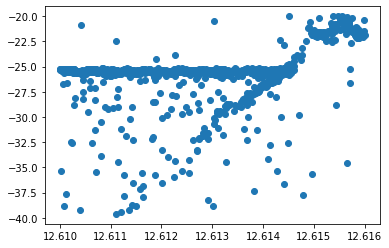

In [ ]:
Df = df.copy()
#Df = Df.loc[Df['confidence code'] == 4]
Df = Df.loc[(Df['latitude'] > 12.61) & (Df['latitude'] < 12.616)]
Df = Df.loc[(Df['photon height'] > -40) & (Df['photon height'] < -20) ]
plt.scatter(Df['latitude'], Df['photon height'])

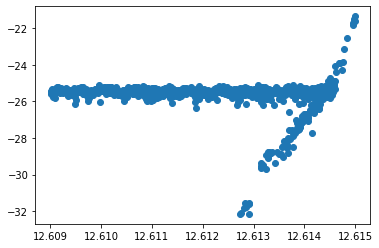

In [ ]:
Df = df.copy()
Df = Df.loc[Df['confidence code'] == 4]
Df = Df.loc[(Df['latitude'] > 12.609) & (Df['latitude'] < 12.615)]
Df = Df.loc[(Df['photon height'] > -40) & (Df['photon height'] < -20) ]
plt.scatter(Df['latitude'], Df['photon height'])

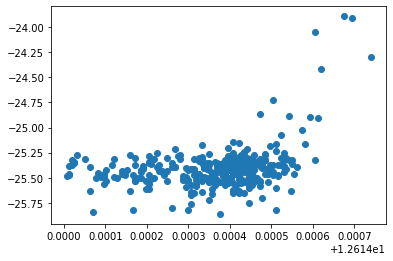

In [ ]:
Df = df.copy()
Df = Df.loc[Df['confidence code'] == 4]
Df = Df.loc[(Df['latitude'] > 12.614) & (Df['latitude'] < 12.61475)]
Df = Df.loc[(Df['photon height'] > -26) & (Df['photon height'] < -20) ]
plt.scatter(Df['latitude'], Df['photon height'])

Select the height of sea floor point cloud (Assume mean sea level H = 0)

Count 97


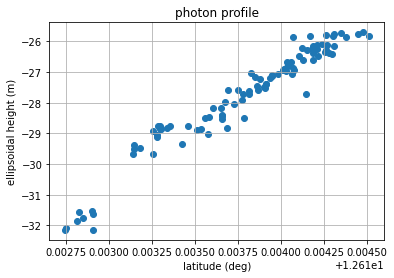

In [ ]:
S1 = (df.loc[(df['latitude'] > 12.609) & (df['latitude'] < 12.615) & (df['confidence code'] == 4)
                & (df['photon height'] > -40) & (df['photon height'] < -27)]).copy()

S2 = (df.loc[(df['latitude'] > 12.614) & (df['latitude'] < 12.615) & (df['confidence code'] == 4)
                & (df['photon height'] > -27) & (df['photon height'] < -26)]).copy()

S3 = (df.loc[(df['latitude'] > 12.614) & (df['latitude'] < 12.61475) & (df['confidence code'] == 4)
                & (df['photon height'] > -26) & (df['photon height'] < -25.70)]).copy()

trainphoton = pd.concat([S1,S2,S3])
print('Count', trainphoton['photon height'].count())

photonplot(trainphoton['latitude'],trainphoton['photon height'])

In [ ]:
# Install Function for Cloud Mask
def maskS2clouds(image) :
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (qa.bitwiseAnd(cloudBitMask).eq(0)) and (qa.bitwiseAnd(cirrusBitMask).eq(0))

  return image.updateMask(mask).divide(10000)

# Map Visualization : Google Earth Engine
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
      tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=name,
      overlay=True,
      control=True
  ).add_to(self)

prepare your satellite image

In [ ]:
############# PREPARED DATA NAJA #############################
# PART 5 SDB FOR MY METHOD 13.450553 13.450553 100.229162 100.231138
lat_min, lat_max, lon_min, lon_max = (12.507892, 12.652677, 101.265584, 101.549246)
AOI = ee.Geometry.Polygon(
        [[[lon_min, lat_max],
           [lon_min, lat_min],
           [lon_max, lat_min],
           [lon_max, lat_max]]])
fromdate = '2021-12-30'
todate = '2022-6-15'

image = ee.ImageCollection('COPERNICUS/S2_SR').filterDate(fromdate,todate).\
          filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than',0.5).\
          filterBounds(AOI).map(maskS2clouds).first().clip(AOI)

if 1 :
  B8_threshold = 0.1

  B8_c = (image.select('B8').lt(B8_threshold)).selfMask()
  B2_lm = image.select('B2').multiply(B8_c)
  B3_lm = image.select('B3').multiply(B8_c)
  B4_lm = image.select('B4').multiply(B8_c)
  B8_lm = image.select('B8').multiply(B8_c)
  image = image.addBands(B2_lm.rename('B2_lm'))
  image = image.addBands(B3_lm.rename('B3_lm'))
  image = image.addBands(B4_lm.rename('B4_lm'))
  image = image.addBands(B4_lm.rename('B8_lm'))
#------------------------------------------------------------------------------------------------
############### VISUALIZATION ############################## 
folium.Map.add_ee_layer = add_ee_layer
c = (AOI.centroid().getInfo())['coordinates']
map_matched = folium.Map(location=[c[1], c[0]], zoom_start=12)

depth_palette = ['blue','cyan', 'green','orange', 'red']

map_matched.add_ee_layer(image,{'min':0, 'max':0.3, 'bands':['B4','B3','B2']},'RGB_L2A')
map_matched.add_ee_layer(image,{'min':0, 'max':0.1, 'bands':['B2_lm']},'BLUE_L2A')

display(map_matched.add_child(folium.LayerControl()))

In [ ]:
trainphoton

,latitude,longitude,photon height,confidence code
32772,12.614146,101.378301,-27.703670,4
32816,12.614064,101.378292,-27.048449,4
32853,12.613981,101.378283,-27.056513,4
32878,12.613949,101.378280,-27.111288,4
32879,12.613949,101.378280,-27.111906,4
...,...,...,...,...
32667,12.614306,101.378318,-25.762090,4
32671,12.614300,101.378317,-25.826885,4
32701,12.614261,101.378313,-25.799225,4
32766,12.614166,101.378303,-25.822392,4


get raster value for sdb production ..

In [ ]:
# SDB Calculate
nB2 = (image.select('B2_lm')).multiply(1000)
nB3 = (image.select('B3_lm')).multiply(1000)
lnB2perlnB3 = (nB2.log()).divide(nB3.log())
image = image.addBands(lnB2perlnB3.rename('lnB2perlnB3'))

  def getvalue(vec) :
    lat,lng = vec
    u_poi = ee.Geometry.Point([lng,  	lat ])
    band = image.select('lnB2perlnB3')
    mydata = band.sample(u_poi, 10).getInfo()
    mylist = (mydata)['features']
    if mylist != [] :
      v1 = ((mylist[0])['properties'])['lnB2perlnB3']
    else :
      v1 = None 
    return [v1]

trainphoton['lnB2perlnB3'] = trainphoton[['latitude', 'longitude']].apply(getvalue, axis=1,  result_type ='expand')

In [ ]:
trainphoton

,latitude,longitude,photon height,confidence code,lnB2perlnB3
32772,12.614146,101.378301,-27.703670,4,0.917257
32816,12.614064,101.378292,-27.048449,4,0.914222
32853,12.613981,101.378283,-27.056513,4,0.917256
32878,12.613949,101.378280,-27.111288,4,0.917256
32879,12.613949,101.378280,-27.111906,4,0.917256
...,...,...,...,...,...
32667,12.614306,101.378318,-25.762090,4,0.917893
32671,12.614300,101.378317,-25.826885,4,0.917893
32701,12.614261,101.378313,-25.799225,4,0.917893
32766,12.614166,101.378303,-25.822392,4,0.917257


In [ ]:
trainphoton = trainphoton[~trainphoton['lnB2perlnB3'].isna()]

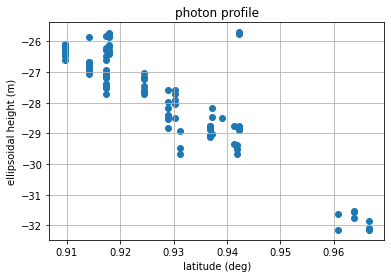

In [ ]:
photonplot(trainphoton['lnB2perlnB3'],trainphoton['photon height'])

bathymetry production -- stumpf algorithm for ellipsoidal height of sea floor

Stumpf 0.8033893214070721 [63.76122392] -98.71579611578942


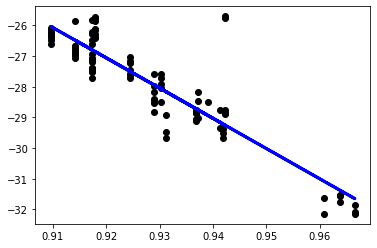

In [ ]:
x_ST = (trainphoton[['lnB2perlnB3']].values).reshape((-1,1)) 
y = (trainphoton[['photon height']].values)
model_sdb_st = LinearRegression().fit(x_ST,y)
print('Stumpf', model_sdb_st.score(x_ST,y), model_sdb_st.intercept_, float(model_sdb_st.coef_) )
plt.scatter(x_ST, y, color = 'black')
plt.plot(x_ST, model_sdb_st.predict(x_ST), color = 'blue', linewidth = 3)
plt.show()

In [ ]:
SDB_ST = ((image.select('lnB2perlnB3')).multiply(float(model_sdb_st.coef_))).add(float(model_sdb_st.intercept_))  
#SDB_ST = m0 + m1((ln1000B2)/(ln1000B3))
image = image.addBands(SDB_ST.rename('SDB_ST'))
print('Stumpf finish ....')

Stumpf finish ....


In [ ]:
############### VISUALIZATION ############################## 
folium.Map.add_ee_layer = add_ee_layer
c = (AOI.centroid().getInfo())['coordinates']
map_matched = folium.Map(location=[c[1], c[0]], zoom_start=12)

depth_palette = ['blue','cyan', 'green','orange', 'red']

map_matched.add_ee_layer(image,{'min':0, 'max':0.3, 'bands':['B4','B3','B2']},'RGB_L2A')
map_matched.add_ee_layer(image,{'min':-36, 'max':-26, 'bands':['SDB_ST'], 'palette' : depth_palette},'h')

display(map_matched.add_child(folium.LayerControl()))

try convert to orthometric height ...

In [ ]:
def MSL(vec):
    lat,lon,h = vec
    geoid_model = '/content/drive/MyDrive/SeniorProject/tgm2017-1.pgm'    # <---- get your geoid model file
    geoid_interpolator = pygeodesy.GeoidKarney(geoid_model)
    # Get the geoid height
    pos = LatLon(lat, lon)
    N = geoid_interpolator(pos)
    return h-N
trainphoton['H'] = trainphoton[['latitude', 'longitude', 'photon height']].apply(MSL, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
trainphoton

,latitude,longitude,photon height,confidence code,lnB2perlnB3,H
32772,12.614146,101.378301,-27.703670,4,0.917257,-1.722467
32816,12.614064,101.378292,-27.048449,4,0.914222,-1.067378
32853,12.613981,101.378283,-27.056513,4,0.917256,-1.075574
32878,12.613949,101.378280,-27.111288,4,0.917256,-1.130400
32879,12.613949,101.378280,-27.111906,4,0.917256,-1.131018
...,...,...,...,...,...,...
32667,12.614306,101.378318,-25.762090,4,0.917893,0.219371
32671,12.614300,101.378317,-25.826885,4,0.917893,0.154566
32701,12.614261,101.378313,-25.799225,4,0.917893,0.182164
32766,12.614166,101.378303,-25.822392,4,0.917257,0.158842


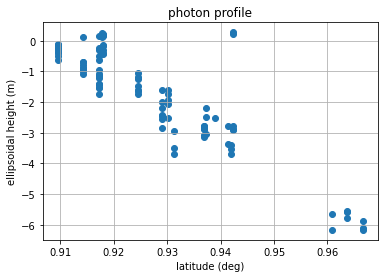

In [ ]:
photonplot(trainphoton['lnB2perlnB3'],trainphoton['H'])

bathymetry production -- stumpf algorithm for orthometric height of sea floor

Stumpf 0.8033893125510205 [89.78001397] -98.75695642014475


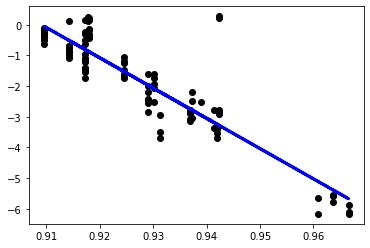

In [ ]:
x_ST = (trainphoton[['lnB2perlnB3']].values).reshape((-1,1)) 
H = (trainphoton[['H']].values)
model_sdb_st = LinearRegression().fit(x_ST,H)
print('Stumpf', model_sdb_st.score(x_ST,H), model_sdb_st.intercept_, float(model_sdb_st.coef_) )
plt.scatter(x_ST, H, color = 'black')
plt.plot(x_ST, model_sdb_st.predict(x_ST), color = 'blue', linewidth = 3)
plt.show()

In [ ]:
SDB_ST_Depth = ((image.select('lnB2perlnB3')).multiply(float(model_sdb_st.coef_))).add(float(model_sdb_st.intercept_))  
#SDB_ST = m0 + m1((ln1000B2)/(ln1000B3))
image = image.addBands(SDB_ST_Depth.rename('SDB_ST_HH'))
print('Stumpf finish ....')

Stumpf finish ....


In [ ]:
############### VISUALIZATION ############################## 
folium.Map.add_ee_layer = add_ee_layer
c = (AOI.centroid().getInfo())['coordinates']
map_matched = folium.Map(location=[c[1], c[0]], zoom_start=12)

depth_palette = ['blue','cyan', 'green','orange', 'red']

map_matched.add_ee_layer(image,{'min':0, 'max':0.3, 'bands':['B4','B3','B2']},'RGB_L2A')
map_matched.add_ee_layer(image,{'min':-30, 'max':0, 'bands':['SDB_ST_HH'], 'palette' : depth_palette},'h')

display(map_matched.add_child(folium.LayerControl()))

In [ ]:
trainphoton.to_csv('traindepth.csv')

In [ ]:
sdb_band = image.select('SDB_ST_HH')

task = ee.batch.Export.image.toDrive(**{
    'image': sdb_band,
    'description': 'icesatonly',
    'folder':'Example_folder',
    'scale': 10,
    'region': AOI.getInfo()['coordinates']
})
task.start()

import time 
while task.active():
  print('Polling for task (id: {}).'.format(task.id))
  time.sleep(5)

Polling for task (id: YHRDHVAMUTS52Z5SGGUB5WLB).
Polling for task (id: YHRDHVAMUTS52Z5SGGUB5WLB).
Polling for task (id: YHRDHVAMUTS52Z5SGGUB5WLB).
Polling for task (id: YHRDHVAMUTS52Z5SGGUB5WLB).
Polling for task (id: YHRDHVAMUTS52Z5SGGUB5WLB).
Polling for task (id: YHRDHVAMUTS52Z5SGGUB5WLB).
Polling for task (id: YHRDHVAMUTS52Z5SGGUB5WLB).
Polling for task (id: YHRDHVAMUTS52Z5SGGUB5WLB).
Polling for task (id: YHRDHVAMUTS52Z5SGGUB5WLB).
Polling for task (id: YHRDHVAMUTS52Z5SGGUB5WLB).
Polling for task (id: YHRDHVAMUTS52Z5SGGUB5WLB).
Polling for task (id: YHRDHVAMUTS52Z5SGGUB5WLB).
Polling for task (id: YHRDHVAMUTS52Z5SGGUB5WLB).
Polling for task (id: YHRDHVAMUTS52Z5SGGUB5WLB).
Polling for task (id: YHRDHVAMUTS52Z5SGGUB5WLB).
Polling for task (id: YHRDHVAMUTS52Z5SGGUB5WLB).
Polling for task (id: YHRDHVAMUTS52Z5SGGUB5WLB).
Polling for task (id: YHRDHVAMUTS52Z5SGGUB5WLB).
Polling for task (id: YHRDHVAMUTS52Z5SGGUB5WLB).
Polling for task (id: YHRDHVAMUTS52Z5SGGUB5WLB).
Polling for task (id